# Formula 1 DNF Tahmini (Did Not Finish)
Bu proje, Formula 1 verileri kullanılarak bir sürücünün yarışı tamamlayıp tamamlayamayacağını (DNF) tahmin etmeye yönelik gözetimli bir makine öğrenmesi uygulamasıdır.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Veri dosyalarını yükle
results = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/results.csv')

# İlk birkaç satıra göz at
results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


In [4]:
# Veri dosyalarını yükle
drivers = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/drivers.csv')

# İlk birkaç satıra göz at
drivers.head()

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [5]:
# Birleştir
results_merged = results.merge(drivers, on='driverId', how='left')

# Sürücü adı sütunu oluştur
results_merged['driver_name'] = results_merged['forename'] + ' ' + results_merged['surname']


In [6]:
# Yarışı tamamlayanlar genelde "1" numaralı statusId'ye sahiptir
# 1 dışındaki statusId'ler DNF (yarış dışı) kabul edilir
results_merged['dnf'] = results_merged['statusId'].apply(lambda x: 0 if x == 1 else 1)

# Kontrol et
results_merged['dnf'].value_counts()


dnf
1    19085
0     7674
Name: count, dtype: int64

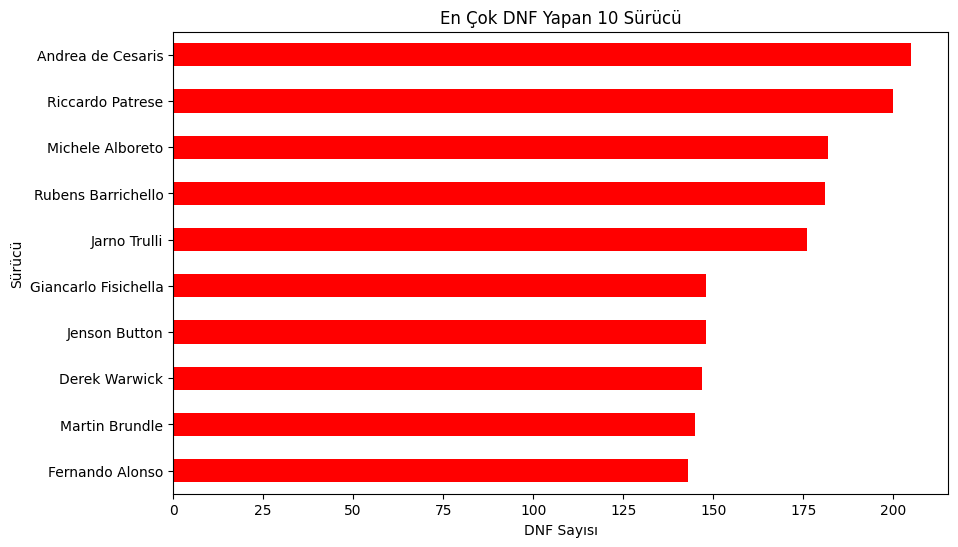

In [7]:
# Sadece DNF olan ve driver_name dolu olanları filtrele
filtered = results_merged[(results_merged['dnf'] == 1) & (results_merged['driver_name'].notnull())]

# En çok DNF yapan 10 sürücü
dnf_counts = filtered['driver_name'].value_counts().head(10)

# Görselleştir
plt.figure(figsize=(10,6))
dnf_counts.plot(kind='barh', color='red')
plt.title('En Çok DNF Yapan 10 Sürücü')
plt.xlabel('DNF Sayısı')
plt.ylabel('Sürücü')
plt.gca().invert_yaxis()
plt.show()


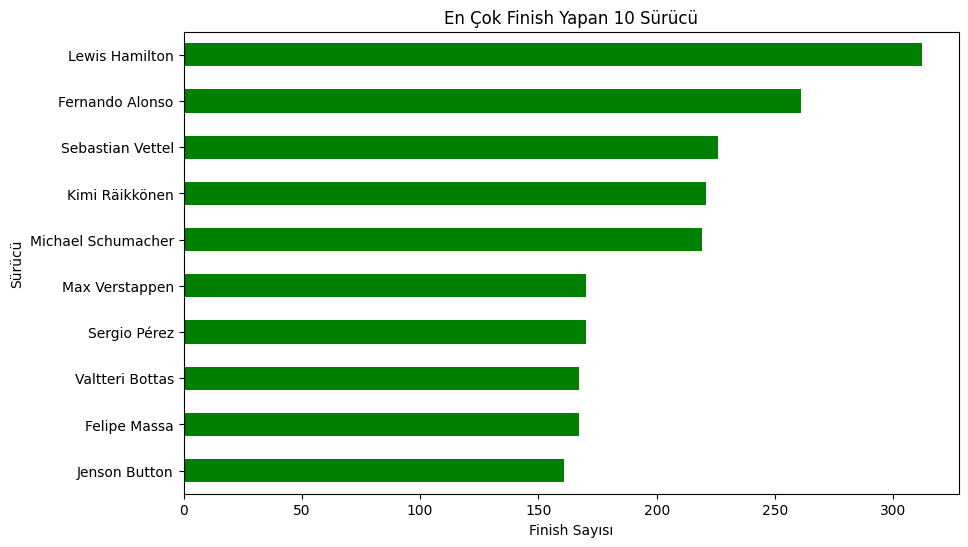

In [8]:
# Sadece yarışı tamamlayan (dnf == 0) ve driver_name dolu olanları filtrele
filtered = results_merged[(results_merged['dnf'] == 0) & (results_merged['driver_name'].notnull())]

# En çok yarışı tamamlayan 10 sürücü
dnf_counts = filtered['driver_name'].value_counts().head(10)

# Görselleştir
plt.figure(figsize=(10,6))
dnf_counts.plot(kind='barh', color='green')
plt.title('En Çok Finish Yapan 10 Sürücü')
plt.xlabel('Finish Sayısı')
plt.ylabel('Sürücü')
plt.gca().invert_yaxis()
plt.show()


In [9]:
# Modelde kullanılacak özellikleri (feature) seçiyoruz
features = ['grid', 'position', 'points', 'laps', 'milliseconds']

In [10]:
df = results_merged[['grid', 'position', 'points', 'laps', 'milliseconds', 'dnf']].copy()
df['position'] = pd.to_numeric(df['position'], errors='coerce')
df['milliseconds'] = pd.to_numeric(df['milliseconds'], errors='coerce')

# Eksik değerleri doldur (özellikle DNF'ler için anlamlı)
df.fillna(-1, inplace=True)


In [11]:
X = df[['grid', 'position', 'points', 'laps', 'milliseconds']]
y = df['dnf']

In [12]:
from sklearn.model_selection import train_test_split

# Veriyi eğitim ve test olarak %80-%20 oranında ayırıyoruz
# stratify=y → Sınıf dağılımını (DNF vs Finish) her iki grupta da korur

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [13]:
y.value_counts()


dnf
1    19085
0     7674
Name: count, dtype: int64

In [14]:
from sklearn.linear_model import LogisticRegression  # Bu satırı ekle

# Dengeli sınıf dağılımı için class_weight='balanced' parametresiyle
# Lojistik regresyon modeli oluşturuluyor ve eğitiliyor
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

Accuracy: 0.9964499252615845
Precision: 0.999211356466877
Recall: 0.9958082263557768
F1 Score: 0.9975068888597297


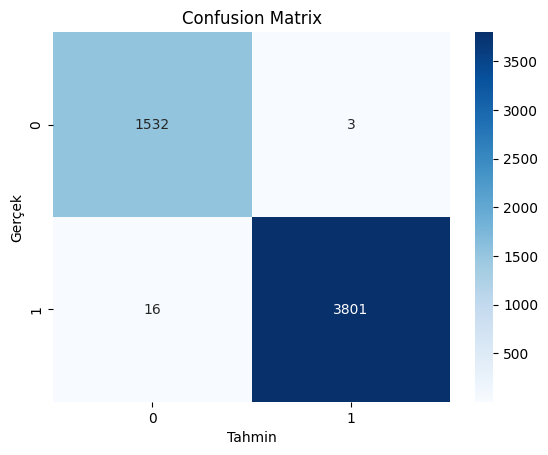

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Test verisi üzerinde eğitilmiş modeli kullanarak tahmin yap
y_pred = model.predict(X_test)

# Performans metriklerini yazdır
# Doğruluk (Accuracy), Kesinlik (Precision), Duyarlılık (Recall), F1 Skoru
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall:", recall_score(y_test, y_pred, zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred, zero_division=0))

# Karışıklık matrisini oluştur ve ısı haritası olarak görselleştir
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Tahmin")   # x ekseni: modelin tahmini
plt.ylabel("Gerçek")   # y ekseni: gerçek etiketler
plt.title("Confusion Matrix")  # grafik başlığı
plt.show()

In [16]:
from sklearn.model_selection import cross_val_score

# cross_val_score ile 5 katlı çapraz doğrulama (5-Fold Cross Validation) uygulanır
# Model farklı veri bölünmelerinde test edilerek daha güvenilir F1 skoru elde edilir
# scoring='f1' → her katmanda F1 skoru hesaplanır (dnf sınıflandırması için uygundur)
scores = cross_val_score(model, X, y, cv=5, scoring='f1')

# Tüm katmanların F1 skorlarını yazdır
print("F1 scores:", scores)

# Ortalama F1 skoru yazdır (modelin genel başarısı)
print("Average F1:", scores.mean())

F1 scores: [0.99446786 0.99934546 0.92207792 0.95639098 0.9968611 ]
Average F1: 0.9738286656677747


In [17]:
# Gerekli sınıflandırma algoritmalarını içe aktar
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Karşılaştırmak üzere farklı sınıflandırma modelleri tanımlanıyor
# class_weight='balanced' → dengesiz sınıflar için otomatik ağırlık verir
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "KNN": KNeighborsClassifier()
}

# Her bir model için 5 katlı çapraz doğrulama ile F1 skoru hesaplanıyor
# Model ismi ve ortalama F1 skoru yazdırılıyor
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='f1')
    print(f"{name}: Average F1 Score = {scores.mean():.4f}")

Logistic Regression: Average F1 Score = 0.9738
Decision Tree: Average F1 Score = 0.9988
Random Forest: Average F1 Score = 0.9989
KNN: Average F1 Score = 0.9988


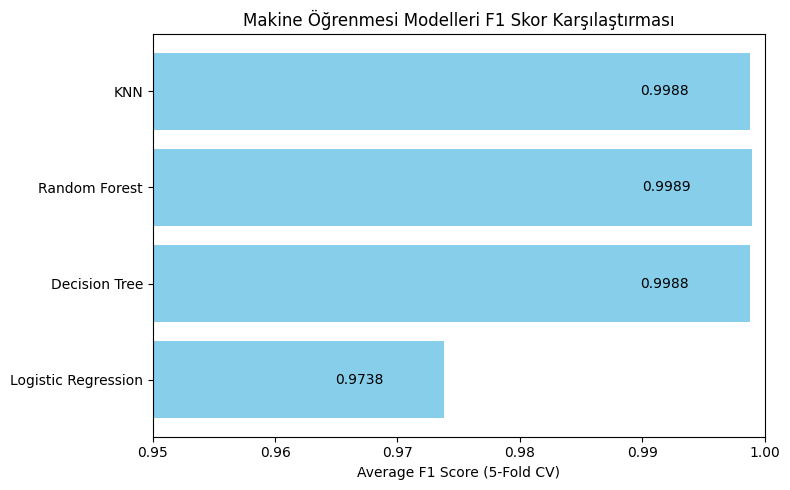

In [18]:
# Gerekli kütüphaneleri içe aktar
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

# Model adları ve her modelin F1 skorunu tutacak liste oluşturuluyor
model_names = list(models.keys())
f1_scores = []

# Her model için 5 katlı çapraz doğrulama ile ortalama F1 skoru hesaplanıyor
for model in models.values():
    score = cross_val_score(model, X, y, cv=5, scoring='f1').mean()
    f1_scores.append(score)

# Görselleştirme: Model isimlerini ve karşılık gelen F1 skorlarını bar grafikte göster
plt.figure(figsize=(8, 5))
bars = plt.barh(model_names, f1_scores, color='skyblue')  # Yatay bar grafiği

# Eksen ve başlık ayarları
plt.xlabel("Average F1 Score (5-Fold CV)")
plt.title("Makine Öğrenmesi Modelleri F1 Skor Karşılaştırması")
plt.xlim(0.95, 1.0)  # F1 skorları yüksek olduğu için zoom yapılır

# Her barın yanına skor etiketini yazdır
for bar, score in zip(bars, f1_scores):
    plt.text(score - 0.005, bar.get_y() + bar.get_height() / 2,
             f'{score:.4f}', va='center', ha='right', color='black')

# Grafik hizalaması ve gösterimi
plt.tight_layout()
plt.show()

In [19]:
from sklearn.ensemble import RandomForestClassifier

# En yüksek F1 skorunu verdiği için Random Forest modeli oluşturuluyor
# class_weight='balanced' → sınıf dengesizliğini otomatik olarak düzeltmek için
# random_state=42 → tekrarlanabilirlik için sabit rastgelelik değeri
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Modeli eğitim verisiyle eğit (fit et)
rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

Random Forest Accuracy: 0.999813153961136
Random Forest Precision: 1.0
Random Forest Recall: 0.9997380141472361
Random Forest F1 Score: 0.9998689899122233


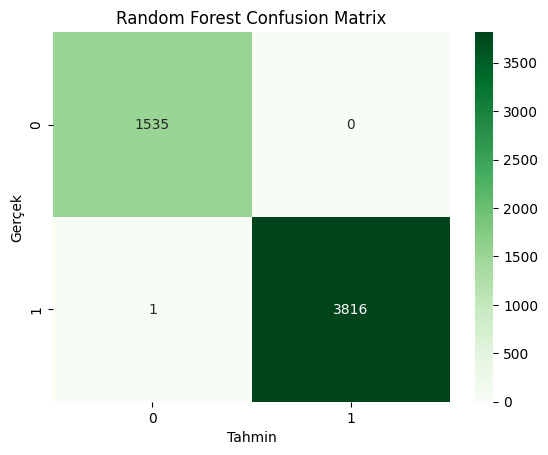

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Test verisi ile tahmin yap
y_pred_rf = rf_model.predict(X_test)

# Random Forest modelinin değerlendirme metriklerini yazdır
# Accuracy  → Genel doğruluk oranı
# Precision → Pozitif tahminlerin ne kadarının doğru olduğu
# Recall    → Gerçek pozitiflerin ne kadarının doğru tahmin edildiği
# F1 Score  → Precision ve Recall’un harmonik ortalaması
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Precision:", precision_score(y_test, y_pred_rf, zero_division=0))
print("Random Forest Recall:", recall_score(y_test, y_pred_rf, zero_division=0))
print("Random Forest F1 Score:", f1_score(y_test, y_pred_rf, zero_division=0))

# Karışıklık matrisi (confusion matrix) ile sınıflandırma başarısını detaylı olarak görselleştir
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')  # Sayısal anotasyon, yeşil tonlarında
plt.xlabel("Tahmin")   # X ekseni: Modelin tahmini
plt.ylabel("Gerçek")   # Y ekseni: Gerçek sınıf etiketi
plt.title("Random Forest Confusion Matrix")
plt.show()

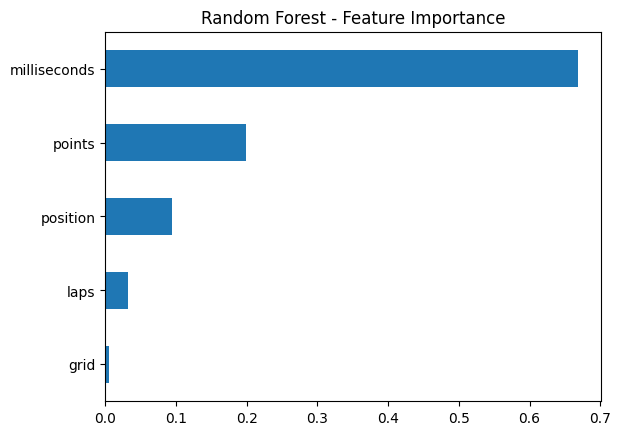

In [21]:
import pandas as pd

# Random Forest modelinde kullanılan her özelliğin (feature) önem derecesini al
# feature_importances_ → Modelin karar verirken hangi sütunlara ne kadar ağırlık verdiğini gösterir
importance = pd.Series(rf_model.feature_importances_, index=X.columns)

# Özellik önemlerini küçükten büyüğe sıralayıp yatay bar grafikte göster
importance.sort_values(ascending=True).plot(kind='barh')

# Grafik başlığı
plt.title("Random Forest - Feature Importance")
plt.show()

#### Sonuç Özeti

Bu projede, Formula 1 yarışlarındaki sürücülerin bir yarışı tamamlayıp tamamlamama durumları (DNF – Did Not Finish) makine öğrenmesi ile tahmin edilmiştir. Amaç, geçmiş yarış verilerinden öğrenerek, benzer koşullardaki sürücülerin gelecekte DNF olma ihtimalini öngörmektir.

Proje sürecinde:
- Formula 1’e ait 1950–2024 yılları arasındaki gerçek yarış verileri kullanılmıştır.
- Hedef değişken olarak `dnf` sütunu (`1` → tamamlamadı, `0` → tamamladı) tanımlanmıştır.
- Eksik veriler `-1` ile doldurularak DNF durumunun doğal veri eksikliğiyle yansımasına izin verilmiştir.
- Kullanılan makine öğrenmesi algoritmaları şunlardır:
  - Logistic Regression
  - Decision Tree
  - Random Forest
  - K-Nearest Neighbors (KNN)
- Bu algoritmalar 5 katlı çapraz doğrulama ile F1 skoru açısından karşılaştırılmıştır.

Sonuç:
- En yüksek başarıyı Random Forest algoritması sağlamış ve nihai model olarak seçilmiştir.
- Model test verisi üzerinde yüksek F1 skoru (~0.9989) ile güçlü performans göstermiştir.

Bu çalışma, gerçek dünya yarış verileriyle eğitilmiş bir makine öğrenmesi modeli sayesinde sürücülerin yarış tamamlama olasılıklarını başarıyla tahmin etmektedir.